# Fine-Tune Gemma2 for Translating the Classical Chinese to  Modern Chinese Translation

We hope to realize the translation between classical Chinese and modern Chinese by training a large language model.

#API configuration

First you need to enter the API for your kaggle's gemma2 model into the following code.

In [ ]:
import json
import os

#enter the API for your kaggle's gemma2 model into the following code
kaggle_api = {"username": your_username, "key": your_key}
with open("/content/kaggle.json", "w") as f:
    json.dump(kaggle_api, f)

os.environ['KAGGLE_CONFIG_DIR'] = "/content"


In [ ]:
!pip install -q -U keras-nlp datasets
!pip install -q -U keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
tf-keras 

# Loading training data

Our training and testing data are sourced from an open repository on GitHub: https://github.com/NiuTrans/Classical-Modern. This repository contains a parallel corpus of traditional and simplified Chinese texts. Each data entry consists of two keys: "古文" (an ancient Chinese phrase) and "现代文" (its corresponding modern translation). For ease of training, we selected a subset of the corpus, focusing on typical examples, including historical texts and classical prose, such as *《梦溪笔谈》* and *《文心雕龙》*. If you want to train a larger data set, you can modify it by adding the following code.

In [ ]:
data=[]

names = ["dataset1.json","dataset2.json","dataset3.json","dataset4.json","dataset5.json","dataset6.json"]
#we choose using these four datasets. If you want to use other dataset or more dataset, please modify the above code.
for name in names:
  with open(name) as f:
      temp = json.load(f)
      for i in temp:

        data.append("Instruction:\n"+i['古文']+"\n\nResponse:\n"+i["现代文"])


# **Loading the model**

In [ ]:
import keras_nlp
import keras

In [ ]:
# Set JAX backend for Keras before importing any Keras modules
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"  # Full memory use for JAX backend

# Run with half precision if needed; uncomment if desired
# keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 256  # Maximum token limit for each training instance
lora_name = "translator"  # Name for LoRA fine-tuning
lora_rank = 4  # Rank for LoRA tuning
lr_value = 1e-4  # Learning rate for fine-tuning
train_epoch = 5  # Number of epochs for training
model_id = "gemma2_instruct_2b_en"  # Model ID

In [ ]:
print(keras_nlp.models.GemmaCausalLM.presets.keys()) # optional keras model we can use, here we use "gemma2_instruct_2b_en"


dict_keys(['gemma_2b_en', 'gemma_instruct_2b_en', 'gemma_1.1_instruct_2b_en', 'code_gemma_1.1_2b_en', 'code_gemma_2b_en', 'gemma_7b_en', 'gemma_instruct_7b_en', 'gemma_1.1_instruct_7b_en', 'code_gemma_7b_en', 'code_gemma_instruct_7b_en', 'code_gemma_1.1_instruct_7b_en', 'gemma2_2b_en', 'gemma2_instruct_2b_en', 'gemma2_9b_en', 'gemma2_instruct_9b_en', 'gemma2_27b_en', 'gemma2_instruct_27b_en', 'shieldgemma_2b_en', 'shieldgemma_9b_en', 'shieldgemma_27b_en'])


In [ ]:
gemma = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

# ***LoRA Fine-Tuning***

First of all, we will show the effect of Gemma2 model in translating classical Chinese.

In [ ]:
# Example usage of the model for generation before we fit the model
prompt = "Instruction:\n「但责己，不责人，此远怨之道也；但信己，不信人，此取败之由也。」翻译成现代汉语\n\nResponse:\n"
output = gemma.generate(prompt, max_length=100) # Adjust max_length as needed
print(output)


Instruction:
「但责己，不责人，此远怨之道也；但信己，不信人，此取败之由也。」翻译成现代汉语

Response:
当只责备自己，不责备别人，这是远大的怨恨的道路；当只相信自己，不相信别人，这是败坏的根源。


In [ ]:
# Enable LoRA for the model and set the LoRA rank (4, 8 or 16).
gemma.backbone.enable_lora(rank=lora_rank)
gemma.summary()

# Limit the input sequence length (to control memory usage).
gemma.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Train the model.

In [ ]:
gemma.fit(data,epochs=10,batch_size=8)

Epoch 1/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 376s 296ms/step - loss: 0.7964 - sparse_categorical_accuracy: 0.4586
Epoch 2/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 333s 262ms/step - loss: 0.7542 - sparse_categorical_accuracy: 0.4768
Epoch 3/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 333s 262ms/step - loss: 0.7400 - sparse_categorical_accuracy: 0.4836
Epoch 4/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 333s 262ms/step - loss: 0.7269 - sparse_categorical_accuracy: 0.4902
Epoch 5/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 333s 262ms/step - loss: 0.7138 - sparse_categorical_accuracy: 0.4975
Epoch 6/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 333s 262ms/step - loss: 0.7005 - sparse_categorical_accuracy: 0.5045
Epoch 7/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 333s 262ms/step - loss: 0.6873 - sparse_categorical_accuracy: 0.5115
Epoch 8/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 333s 262ms/step - loss: 0.6742 - sparse_categorical_accuracy: 0.5187
Epoch 9/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 333s 262ms/step - loss: 0.6613 - sparse_categorical_accuracy: 0.5264
E

In [ ]:
# Example usage of the model for generation after fitting
prompt = "Instruction:\n「正而过则迂，直而过则拙，故迂拙之人，犹不失为正直。」\n\nResponse:\n"
output = gemma.generate(prompt, max_length=100) # Adjust max_length as needed
print(output)

Instruction:
「正而过则迂，直而过则拙，故迂拙之人，犹不失为正直。」

Response:
正而过则迂，直而过则拙，所以迂拙之人，还是不失为正直。


If you want to test the translation of classical Chinese for yourself, all you need to do is to change the above words, *「正而过则迂，直而过则拙，故迂拙之人，犹不失为正直。」*, to the classical Chinese you want.

# Evaluation

In [ ]:
!pip install git+https://github.com/huggingface/trl.git
!pip install -U bitsandbytes
!pip install ipywidgets
!pip install python-dotenv
!pip install -U peft
!pip install matplotlib
!pip install seaborn
!pip install wordcloud
!pip install nltk
!pip install rouge_score
!pip install evaluate

  Cloning https://github.com/huggingface/trl.git to /tmp/pip-req-build-h_fucnbj
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-h_fucnbj
  Resolved https://github.com/huggingface/trl.git to commit aed5da580e9fcba6517460daf65106bc42fb6167
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for trl: filename=trl-0.14.0.dev0-py3-none-any.whl size=288412 sha256=79cdbfe031c74b1fb044b2ad22500ab019f76316901e2d6ed812733f79edd3f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-e584ed6e/wheels/22/0e/42/319b77b2648bb6140ef2b08b0478ede9ca3cc7879fcd022d36
Successfully built trl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-n

In [ ]:
test=[]
names = ["test.json"]
for name in names:
  with open(name) as f:
      temp = json.load(f)
      for i in temp:

        test.append("Instruction:\n"+i['古文']+"\n\nResponse:\n"+i["现代文"])

In [ ]:
def get_response_text(text):
  # Find the Chinese content after "Response:"
  start_marker = "Response:"
  start_idx = text.find(start_marker) + len(start_marker)

  #The end location is located by a newline
  end_idx = len(text)

  response_text = text[start_idx:end_idx].strip()
  return response_text

In [ ]:
def get_instruction_text(text):
    # Find the location of "Instruction:" and "Response:"
    start_marker = "Instruction:"
    end_marker = "Response:"
    start_idx = text.find(start_marker) + len(start_marker)
    end_idx = text.find(end_marker)

    # Extract the contents of the Instruction section
    instruction_text = text[start_idx:end_idx].strip()

    # Construct a new format
    response_text = f"Instruction:\n「{instruction_text}」翻译为现代汉语\n\nResponse:\n"
    return response_text


In [ ]:
refer_data=[]
test_data=[]
for i in test:
  test_data.append(get_response_text(gemma.generate(get_instruction_text(i), max_length=1000)))
  refer_data.append(get_response_text(i))


We know that BLEU is widely used in translation tasks. So, we use the BLEU to evaluate the translation from classical Chinese to modern Chinese.

In [ ]:
import evaluate
import jieba
from nltk.translate.bleu_score import sentence_bleu

score_data=[]

for i in range(len(refer_data)):
  references_t = " ".join(jieba.cut(refer_data[i])).split(" ")
  predictions_t = " ".join(jieba.cut(test_data[i])).split(" ")
  references = [references_t]
  predictions = predictions_t
  score = sentence_bleu(references, predictions)
  score_data.append(score)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

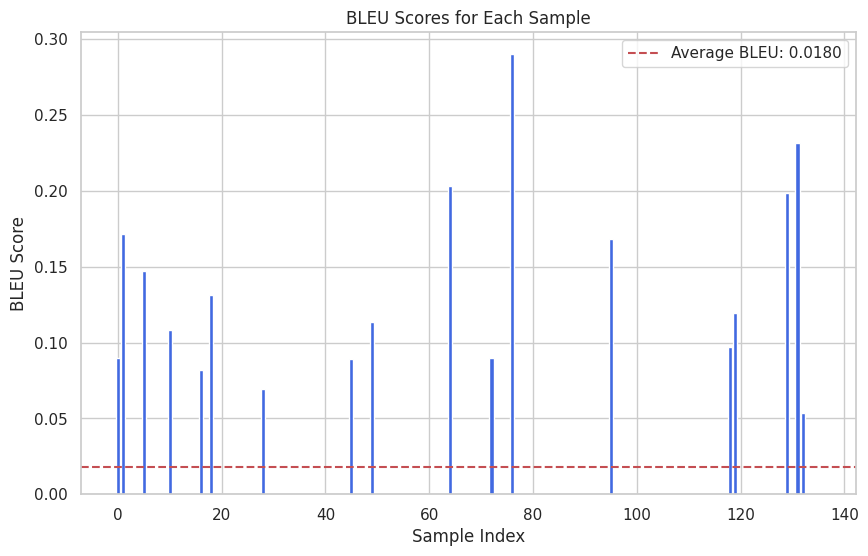

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
bleu_scores = score_data
# Plotting BLEU score
plt.figure(figsize=(10, 6))
plt.bar(range(len(bleu_scores)), bleu_scores, color='royalblue')
average_bleu_score=sum(score_data)/len(score_data)
plt.axhline(y=average_bleu_score, color='r', linestyle='--', label=f"Average BLEU: {average_bleu_score:.4f}")
plt.xlabel("Sample Index")
plt.ylabel("BLEU Score")
plt.title("BLEU Scores for Each Sample")
plt.legend(loc="best")
plt.show()

Use the BLEU to evaluate the translation and plot the BLEU score on each sample id. From the result, we can find that the average BLEU is 0.01, which is not good. Maybe, it only measures the surface overlap of words and cannot measure whether translation is accurate or natural, especially in a highly flexible language such as classical Chinese.

We want to know why the BLEU evaluation is not so good. And we have found that there is currently no reliable metric for evaluating the translation of Classical Chinese into Modern Chinese. So, we random choose ten samples from the dataset and find the translation results.
We can easily see that the translation of classical texts aligns with the intended meaning. Then we check all samples in the test dataset and the translation of classical Chinese texts conveys the general meaning.

In [ ]:
import random

random.seed(14)
random_numbers = random.sample(range(1, len(test)), k=10)
a=1
for i in random_numbers:
  print(a)
  print(test[i]+"\n")
  print(test_data[i])
  print(score_data[i])
  print("\n")
  a=a+1

1
Instruction:
无财非贫，无学乃为贫；无位非贱，无耻乃为贱；无年非夭，无述乃为夭；无子非孤，无德乃为孤。

Response:
有钱财不算贫穷，没有学问才是真正贫穷；没有地位不算卑下，没有羞耻心才是真正的卑下；活不长久不算短命，没有值得称述的事才是真正的短命；没有子女不算孤独，没有道德才是真正的孤独。

没有财物就是贫穷，没有学识就是贫穷；没有地位就是地位低下，没有耻辱就是地位低下。没有年华就是夭折，没有言论就是夭折。没有子嗣就是孤身，没有德行就是孤身。
0.06945290949974266


2
Instruction:
言不可尽信，必揆诸理；事未可遽行，必问诸心。

Response:
于说的话不可以完全相信，一定在要理性上加以判断、衡量，看看有没有不实之外。

言不可完全相信，必须根据道理来判断；事未可立即实行，必须根据心志来思考。
2.1170548494195007e-78


3
Instruction:
念祖考创家基，不知栉风沐雨，受多少苦辛，才能足食足衣，以贻后世；为子孙计长久，除却读书耕田，恐别无生活，总期克勤克俭，毋负先人。

Response:
到祖先创立家业，不知受过多少艰辛，经过多少努力，才能够衣食暖饱，留下财产给后代子孙。若要为子孙作长久的打算，除了读书和耕田外，恐怕就没有别的了，总希望他们能勤俭生活，不要辜负了先人的辛劳。

是考虑祖先创立家业，不知受过多少风雨，受过多少辛劳，才得以衣食安稳，衣食充足，以此为后代的遗产；是考虑子孙的长久，就剥夺了读书耕田的自由，恐怕就别没有生活了，总希望勤劳俭朴，不要辜负祖先。
0.20352850089060143


4
Instruction:
义之中有利，而尚义之君子，初非计及于利也；利之中有害，而趋利之小人，并不顾其为害也。

Response:
义行之中也会得到利益，这个利益是重视义理的君子始料所不及的。在谋利中也会有不好的事情发生，这是一心求利的小人不愿意得到却最终得到的结果。

义本身有利，而尚义之君子，初非计及于利也；利本身有害，而趋利之小人，并不顾及利害之差。
7.61286725748855e-232


5
Instruction:
粟实之肉秘于内，深自防护，人乃剖而食之；食之而弃其壳，绝无生理矣，此可知多藏者必厚亡也。

Response:
子的果肉深藏在壳内